In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/alvra_tools/')

In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *

[INFO][corrections] Numba not available, reverting to Numpy


In [3]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

pede_file = "/das/work/p17/p17983/Example_data/res/JF_pedestals/pedestal_20190706_1050.JF02T09V02.res.h5"

gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]

print("Dimensions of G: ", G.shape)
print("Dimensions of P: ", P.shape)
print("Dimensions of mask: ", mask.shape)

# Detector name for loading module map and applying geometry
detector_name = "JF02T09V02"

Dimensions of G:  (4, 4608, 1024)
Dimensions of P:  (4, 4608, 1024)
Dimensions of mask:  (4608, 1024)


In [4]:
DIR = "/das/work/p17/p17983/Example_data/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/"

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

There are 244 files in the folder /das/work/p17/p17983/Example_data/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/


In [5]:
filename = "Febpy_monoscan_200mJ_5ps_001_step0060.JF02T09V02.h5"

images_on, images_off, pulse_ids = load_JF_data_on_off(DIR + filename, 25, 12.5, nshots=None)

In [6]:
nframes = images_on.shape[0]
print('number of frames')
print(nframes)
nframes = 100


number of frames
250


In [7]:
total_on = 0
total_off = 0

for i in range(nframes):
    image_on = images_on[i, :]
    image_on = ju.apply_gain_pede(image_on, G=G, P=P, pixel_mask=mask, highgain=False)
    image_on_thr = image_on.copy()
    image_on_thr[image_on < 4] = 0
    #image_on_thr[image_on > 100] = 0
    total_on += image_on_thr
    
    image_off = images_off[i, :]
    image_off = ju.apply_gain_pede(image_off, G=G, P=P, pixel_mask=mask, highgain=False)
    image_off_thr = image_off.copy()
    image_off_thr[image_off < 4] = 0
    #image_off_thr[image_off > 100] = 0
    total_off += image_off_thr

total_on_corr = ju.apply_geometry(total_on, detector_name)
total_off_corr = ju.apply_geometry(total_off, detector_name)

print(total_on_corr.shape)
print(total_off_corr.shape)




(514, 9318)
(514, 9318)


<IPython.core.display.Javascript object>


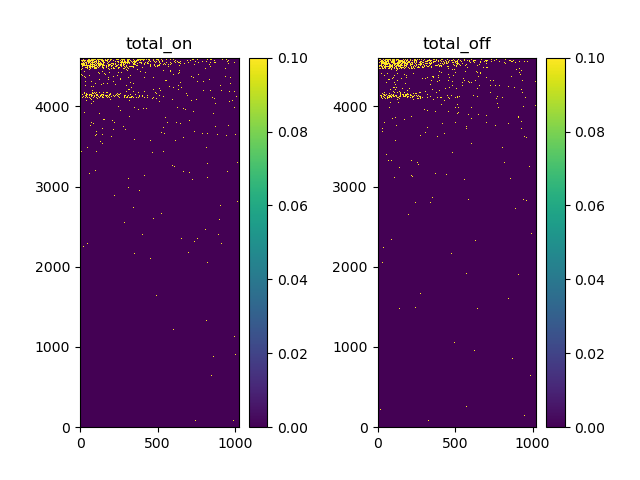

<IPython.core.display.Javascript object>


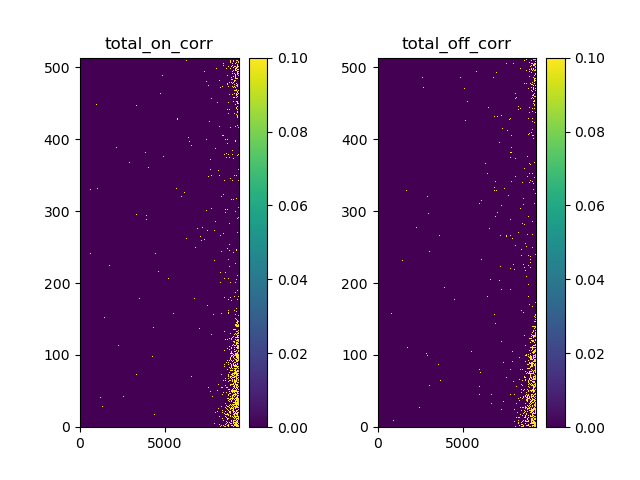

In [8]:
plt.figure()
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)
plt.imshow(total_on, origin="lower", aspect='auto', vmin=0, vmax=0.1)
plt.colorbar()
plt.title('total_on')
plt.subplot(122)
plt.imshow(total_off, origin="lower", aspect='auto', vmin=0, vmax=0.1)
plt.colorbar()
plt.title('total_off')
plt.show()

plt.figure()
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)
plt.imshow(total_on_corr, origin="lower", aspect='auto', vmin=0, vmax=0.1)
plt.colorbar()
plt.title('total_on_corr')
plt.subplot(122)
plt.imshow(total_off_corr, origin="lower", aspect='auto', vmin=0, vmax=0.1)
plt.colorbar()
plt.title('total_off_corr')
plt.show()


9318
(514, 9318)


<IPython.core.display.Javascript object>


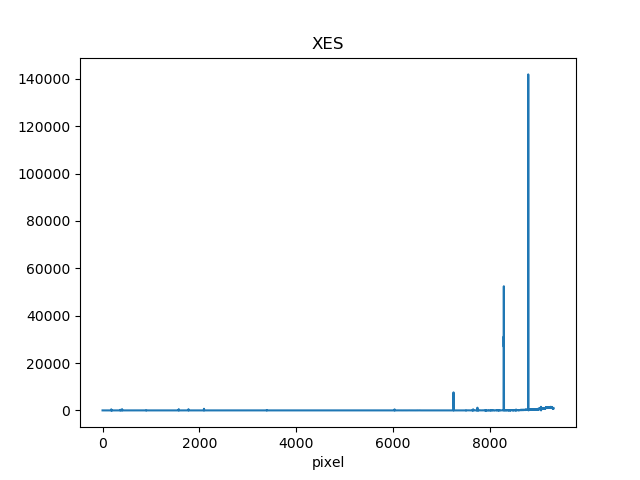

9318
(514, 9318)


<IPython.core.display.Javascript object>


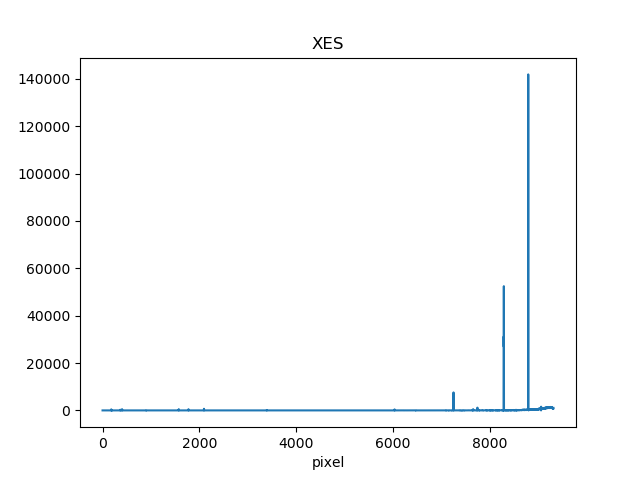

<IPython.core.display.Javascript object>


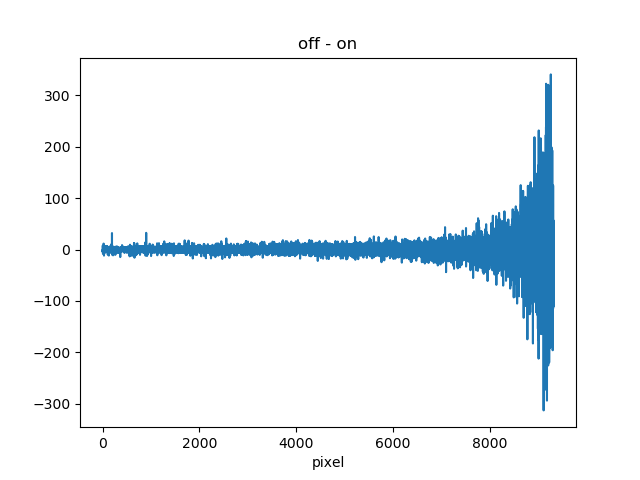

Text(0.5, 1.0, 'off - on')

In [9]:
XES_off = np.sum(total_off_corr,axis=0)
print(XES_off.size)
print(total_off_corr.shape)

plt.figure()
plt.plot(XES_off)
plt.xlabel('pixel')
plt.title('XES')

XES_on = np.sum(total_on_corr,axis=0)
print(XES_on.size)
print(total_on_corr.shape)

plt.figure()
plt.plot(XES_on)
plt.xlabel('pixel')
plt.title('XES')

plt.figure()
plt.plot(XES_off-XES_on)
plt.xlabel('pixel')
plt.title('off - on')

